In [136]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-and-ethereum-prices-from-start-to-2023/Ethereum prices.csv
/kaggle/input/bitcoin-and-ethereum-prices-from-start-to-2023/Bitcoin prices.csv


In [137]:
df = pd.read_csv('/kaggle/input/bitcoin-and-ethereum-prices-from-start-to-2023/Bitcoin prices.csv')

# Exploring Data

In [138]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
1,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
3,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
4,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600


In [139]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3120,2023-04-04,27795.273438,28433.742188,27681.304688,28168.089844,28168.089844,15284538859
3121,2023-04-05,28169.726563,28739.238281,27843.763672,28177.984375,28177.984375,17052315986
3122,2023-04-06,28175.226563,28178.384766,27738.759766,28044.140625,28044.140625,13837809380
3123,2023-04-07,28038.966797,28111.593750,27794.031250,27925.859375,27925.859375,10861680497
3124,2023-04-08,27923.234375,28158.269531,27887.365234,28032.187500,28032.187500,9243753472


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3125 entries, 0 to 3124
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3125 non-null   object 
 1   Open       3125 non-null   float64
 2   High       3125 non-null   float64
 3   Low        3125 non-null   float64
 4   Close      3125 non-null   float64
 5   Adj Close  3125 non-null   float64
 6   Volume     3125 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 171.0+ KB


In [141]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3.125000e+03
mean,13186.265595,13515.583806,12823.837626,13193.565130,13193.565130,1.660684e+10
std,16047.435766,16456.130052,15578.340888,16044.562412,16044.562412,1.978543e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,715.554993,736.452026,705.260010,716.411011,716.411011,1.123540e+08
50%,7361.459961,7526.419922,7220.991211,7361.660156,7361.660156,9.029176e+09
75%,19053.203125,19348.416016,18553.296875,19067.634766,19067.634766,2.811148e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [142]:
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

# EDA

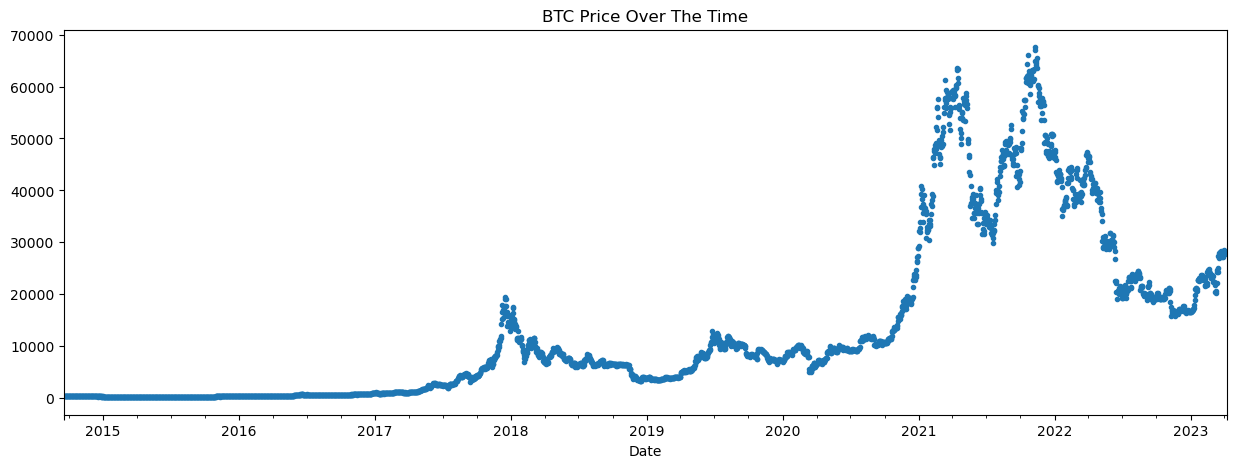

In [143]:
df['Close'].plot(style='.',
        figsize=(15, 5), 
        title='BTC Price Over The Time')
plt.show()

<AxesSubplot:ylabel='Frequency'>

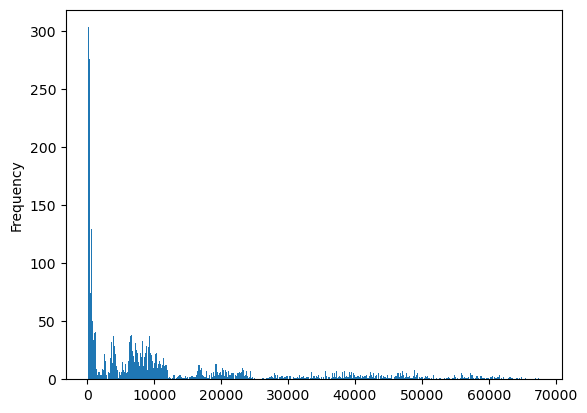

In [144]:
df['Close'].plot(kind='hist', bins=500)

**The distribution of the BTC price seems not like Normal Distribution**

In [145]:
df['Close'] = np.log1p(df['Close'])

<AxesSubplot:ylabel='Frequency'>

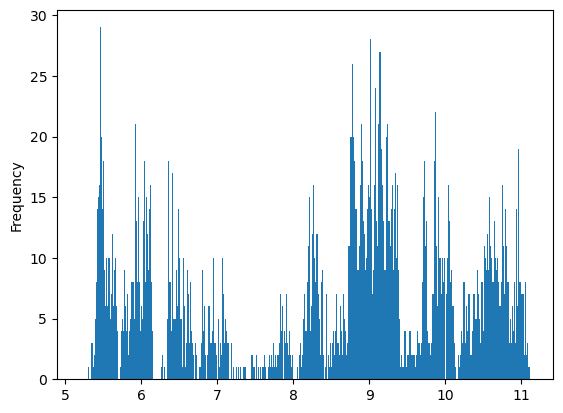

In [146]:
df['Close'].plot(kind='hist', bins=500)

# Creating Features

In [147]:
target_map = df['Close'].to_dict()
df['BTC+1'] = (df.index + pd.Timedelta('1 days')).map(target_map)
df['BTC+2'] = (df.index + pd.Timedelta('2 days')).map(target_map)
df['BTC+3'] = (df.index + pd.Timedelta('3 days')).map(target_map)
df

,Open,High,Low,Close,Adj Close,Volume,BTC+1,BTC+2,BTC+3
Date,,,,,,,,,
2014-09-18,456.859985,456.859985,413.104004,6.053124,424.440002,34483200,5.980899,6.015923,5.991017
2014-09-19,424.102997,427.834991,384.532013,5.980899,394.795990,37919700,6.015923,5.991017,5.999314
2014-09-20,394.673004,423.295990,389.882996,6.015923,408.903992,36863600,5.991017,5.999314,6.079455
2014-09-21,408.084991,412.425995,393.181000,5.991017,398.821014,26580100,5.999314,6.079455,6.050217
2014-09-22,399.100006,406.915985,397.130005,5.999314,402.152008,24127600,6.079455,6.050217,6.022416
...,...,...,...,...,...,...,...,...,...
2023-04-04,27795.273438,28433.742188,27681.304688,10.245981,28168.089844,15284538859,10.246332,10.241571,10.237344
2023-04-05,28169.726563,28739.238281,27843.763672,10.246332,28177.984375,17052315986,10.241571,10.237344,10.241144
2023-04-06,28175.226563,28178.384766,27738.759766,10.241571,28044.140625,13837809380,10.237344,10.241144,NaN


In [148]:
df['moving_avg'] = df['Close'].rolling(window = 20).mean()
df['ema_12'] = df['Close'].ewm(span = 12, adjust = False).mean()
df['ema_26'] = df['Close'].ewm(span = 26, adjust = False).mean()
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust = False).mean()
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window = 14).mean()
avg_loss = loss.rolling(window = 14).mean()
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))
aroon_up = 100 * ((25 - (df['Close'].rolling(25).apply(lambda x: x.argmax() + 1))) / 25)
aroon_down = 100 * ((25 - (df['Close'].rolling(25).apply(lambda x: x.argmin() + 1))) / 25)
df['aroon_oscillator'] = aroon_up - aroon_down
df.tail()

,Open,High,Low,Close,Adj Close,Volume,BTC+1,BTC+2,BTC+3,moving_avg,ema_12,ema_26,macd,macd_signal,rsi,aroon_oscillator
Date,,,,,,,,,,,,,,,,
2023-04-04,27795.273438,28433.742188,27681.304688,10.245981,28168.089844,15284538859,10.246332,10.241571,10.237344,10.228633,10.232040,10.191159,0.040881,0.045557,49.946399,-80.0
2023-04-05,28169.726563,28739.238281,27843.763672,10.246332,28177.984375,17052315986,10.241571,10.237344,10.241144,10.234511,10.234238,10.195246,0.038993,0.044244,56.977322,-76.0
2023-04-06,28175.226563,28178.384766,27738.759766,10.241571,28044.140625,13837809380,10.237344,10.241144,NaN,10.235629,10.235366,10.198677,0.036689,0.042733,47.332774,-72.0
2023-04-07,28038.966797,28111.593750,27794.031250,10.237344,27925.859375,10861680497,10.241144,NaN,NaN,10.237378,10.235671,10.201542,0.034129,0.041012,54.678236,-64.0
2023-04-08,27923.234375,28158.269531,27887.365234,10.241144,28032.187500,9243753472,NaN,NaN,NaN,10.237366,10.236513,10.204475,0.032038,0.039217,55.674090,-64.0


In [149]:
df.drop(['2023-04-06','2023-04-07','2023-04-08'], inplace = True)

In [150]:
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)

# Train/Test Split

In [151]:
size = int(len(df) * 0.8)
df_train = df.iloc[:size]
df_test = df.iloc[size:]

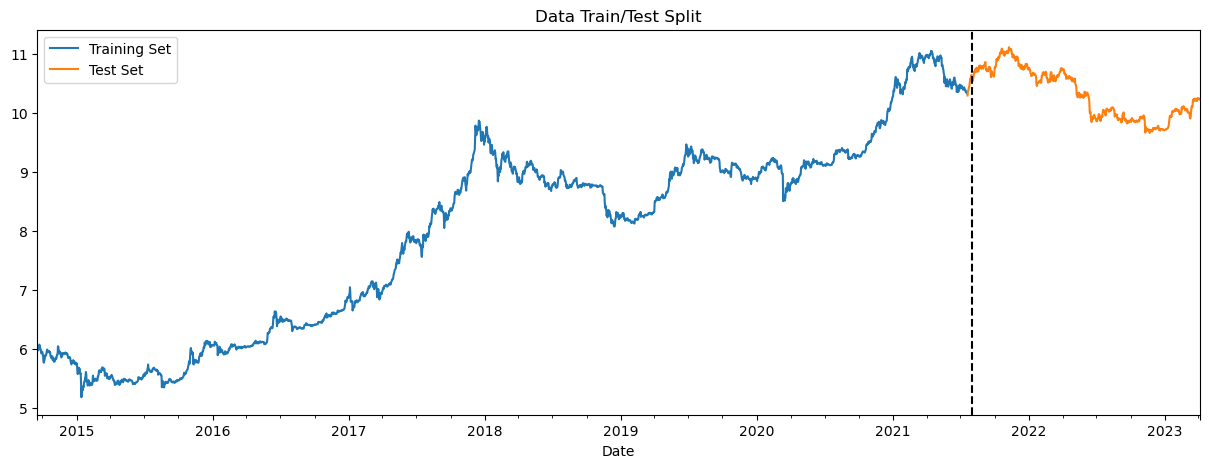

In [152]:
fig, ax = plt.subplots(figsize=(15, 5))
df_train['Close'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
df_test['Close'].plot(ax=ax, label='Test Set')
ax.axvline('2021-07-31', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [153]:
y_train = df_train['BTC+1']
y_test = df_test['BTC+1']
x_train = df_train.drop(['Close', 'BTC+1','BTC+2','BTC+3'], axis =1)
x_test = df_test.drop(['Close','BTC+1', 'BTC+2', 'BTC+3'], axis = 1)

# Model Training

In [154]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,learning_rate=0.01)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[13:34:19] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.55091	validation_1-rmse:9.74001
[100]	validation_0-rmse:2.77516	validation_1-rmse:3.52364
[200]	validation_0-rmse:1.02221	validation_1-rmse:1.25155
[300]	validation_0-rmse:0.38045	validation_1-rmse:0.43727
[400]	validation_0-rmse:0.14837	validation_1-rmse:0.16842
[500]	validation_0-rmse:0.07027	validation_1-rmse:0.11675
[578]	validation_0-rmse:0.05154	validation_1-rmse:0.11816


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

# Results

In [155]:
y_pred = reg.predict(x_test)
y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)
score = np.sqrt(mean_squared_error(y_test, y_pred))
score

3985.5109438580007

In [156]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.9166323782231306

In [157]:
pred_vs_actual = pd.DataFrame(data = [y_pred, y_test]).T
pred_vs_actual.columns = ['Pred', 'Actual']
pred_vs_actual['Date'] = x_test.index + pd.Timedelta('1 days')
pred_vs_actual = pred_vs_actual.set_index('Date')
pred_vs_actual

,Pred,Actual
Date,,
2021-07-21,29680.714844,32110.693359
2021-07-22,30802.640625,32313.105469
2021-07-23,30652.541016,33581.550781
2021-07-24,30841.943359,34292.445313
2021-07-25,31733.751953,35350.187500
...,...,...
2023-04-02,32702.642578,28199.308594
2023-04-03,31837.880859,27790.220703
2023-04-04,31656.820312,28168.089844


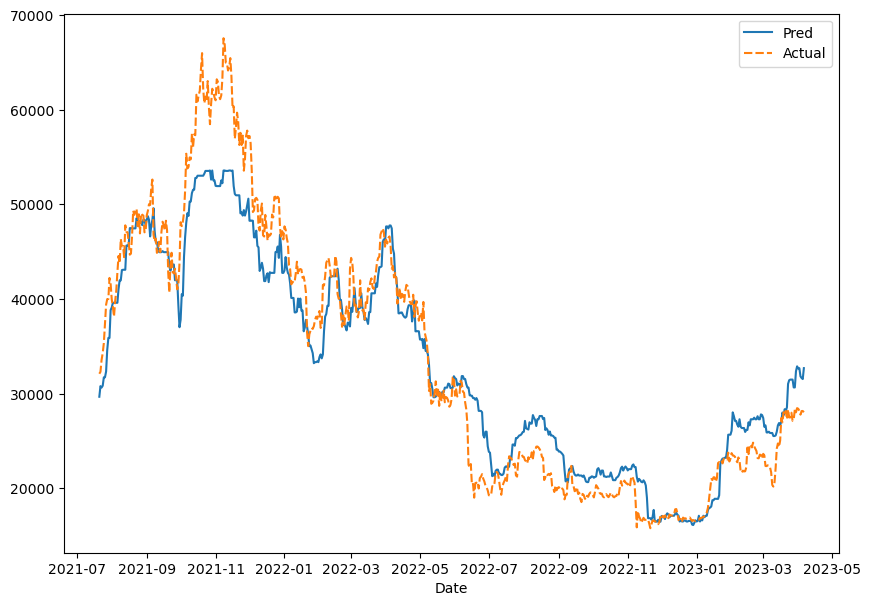

In [158]:
plt.figure(figsize=(10,7))
sns.lineplot(data = pred_vs_actual)
plt.show()